In [97]:
# import siconos package
import siconos.kernel as sk
# numpy for vectors and matrices
import numpy as np

In [98]:
# dynamical system parameters
Lvalue = 1e-2    # inductance
Cvalue = 1e-6    # capacitance
Rvalue = 1e3     # resistance
Vinit = 10.0     # initial voltage
x0 = [Vinit, 0.] # initial state
# A matrix of the linear oscillator
A = np.zeros((2, 2), dtype=np.float64)
A.flat[...] = [0., -1.0/Cvalue, 1.0/Lvalue, 0.]

In [99]:
# build the dynamical system
ds = sk.FirstOrderLinearDS(x0, A)

In [100]:
# --- build an interaction ---
interaction_size = 4  # number of constraints

# B, C, D matrices of the relation
C = [[0.,   0.],
     [0,    0.],
     [-1.,  0.],
     [1.,   0.]]

D = [[1./Rvalue, 1./Rvalue, -1.,  0.],
     [1./Rvalue, 1./Rvalue,  0., -1.],
     [1.,        0.,         0.,  0.],
     [0.,        1.,         0.,  0.]]

B = [[0.,        0., -1./Cvalue, 1./Cvalue],
     [0.,        0.,  0.,        0.       ]]

In [101]:
relation= sk.FirstOrderLinearTIR(C, B)
relation.setDPtr(D)

In [102]:
nonsmooth_law = sk.ComplementarityConditionNSL(interaction_size)

In [103]:
interaction = sk.Interaction(nonsmooth_law, relation)

In [104]:
# dynamical systems and interactions must be gathered into a model
t0 = 0. # initial time
T = 5.0e-3 # duration of the simulation
DiodeBridge = sk.Model(t0, T)
# add the dynamical system in the non smooth dynamical system
DiodeBridge.nonSmoothDynamicalSystem().insertDynamicalSystem(ds)

# link the interaction and the dynamical system
DiodeBridge.nonSmoothDynamicalSystem().link(interaction, ds)
# --- The modeling part is now complete ---

In [105]:
# -- Simulation of the nonsmooth dynamical system --
# time integration of the dynamics
theta = 0.5
osi = sk.EulerMoreauOSI(theta)
osi.insertDynamicalSystem(ds)

In [106]:
# nonsmooth problem formulation and solver
import siconos.numerics as sn
osnspb = sk.LCP(sn.SICONOS_LCP_NSQP)

In [107]:
# simulation and time discretisation
time_step =  1.0e-6
td = sk.TimeDiscretisation(t0, time_step)
simu = sk.TimeStepping(td, osi, osnspb)

In [108]:
# initialize model with simulation
DiodeBridge.initialize(simu)

In [109]:
N = int((T - t0) / time_step)
data_plot = np.zeros((N + 1, 8))
y = interaction.y(0)
lamb = interaction.lambda_(0)
x = ds.x()
k = 0
data_plot[k, 1] = x[0] #  inductor voltage
data_plot[k, 2] = x[1] # inductor current
data_plot[k, 3] = y[0] # diode R1 current
data_plot[k, 4] = - lamb[0] # diode R1 voltage
data_plot[k, 5] = - lamb[1] # diode F2 voltage 
data_plot[k, 6] = lamb[2] # diode F1 current
data_plot[k, 7] = y[0] + lamb[2] # resistor current
while simu.hasNextEvent():
    k += 1
    simu.computeOneStep()
    data_plot[k, 0] = simu.nextTime()
    data_plot[k, 1] = x[0]
    data_plot[k, 2] = x[1]
    data_plot[k, 3] = y[0]
    data_plot[k, 4] = - lamb[0]
    data_plot[k, 5] = - lamb[1]
    data_plot[k, 6] = lamb[2]
    data_plot[k, 7] = y[0] + lamb[2]
    simu.nextStep()


In [114]:
import matplotlib.pyplot as plt
%matplotlib inline

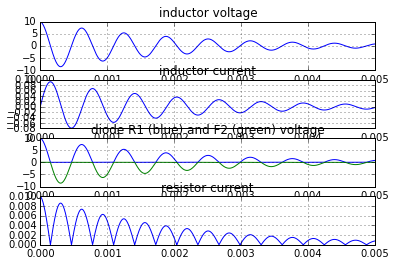

In [115]:
plt.subplot(411)
plt.title('inductor voltage')
plt.plot(data_plot[0:k - 1, 0], data_plot[0:k - 1, 1])
plt.grid()
plt.subplot(412)
plt.title('inductor current')
plt.plot(data_plot[0:k - 1, 0], data_plot[0:k - 1, 2])
plt.grid()
plt.subplot(413)
plt.title('diode R1 (blue) and F2 (green) voltage')
plt.plot(data_plot[0:k - 1, 0], -data_plot[0:k - 1, 4])
plt.plot(data_plot[0:k - 1, 0], data_plot[0:k - 1, 5])
plt.grid()
plt.subplot(414)
plt.title('resistor current')
plt.plot(data_plot[0:k - 1, 0], data_plot[0:k - 1, 7])
plt.grid()

In [96]:
N

5000